In [1]:
#pip install numpy


In [2]:
#pip install pandas

In [3]:
#pip install seaborn

In [4]:
#pip install plotly

In [5]:
#pip install statsmodels

In [6]:
#pip install yfinance

In [7]:
#pip install scikit-learn

In [8]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
import itertools # Importando itertools para generar combinaciones de columnas
# Importando la función seasonal_decompose para la descomposición de series temporales
from statsmodels.tsa.seasonal import seasonal_decompose
import matplotlib.patches as mpatches
import payments_manager as pm
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_curve, auc
# Importa la función para crear la matriz de confusión
from sklearn.metrics import classification_report, confusion_matrix

from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

cr_cp = pm.df('cr_cp')
fe_cp = pm.df('fe_cp')
df_jo = pm.df('df_jo')
#df_jo = pm.sort("df_jo", ["id_cr"]).reset_index()
#df_jo = df_jo.drop(columns=['index'])
#df_jo = df_jo.drop(columns=['Mes_created_at'])
#df_jo_cp = df_jo.copy()
df_jo = pm.sort("df_jo", ["id_cr"]).reset_index()
df_jo = df_jo.drop(columns=['index'])
#df_jo.info()


In [9]:
pd.options.display.max_columns = None
pm.format_to_dates(df_jo, time_format='d') # 'min','s'
df = pm.df('df_hyper')
display(df)

,user_id,created_at_slot,created_at_dow,amount,needs_m_check_recov,n_fees,n_backs,n_recovery,n_incidents,transfer_type,charge_moment,n_cr_fe_w,category,inflation,GBP_EUR,BTC_GBP,unemploy_rate
0,47,13,1,1.0,1,0,0,0,1,regular,NaN,NaN,NaN,1.3,1.16935,6347.577148,3.9
1,99001309,14,0,100.0,0,0,1,0,0,regular,NaN,1.0,NaN,1.3,1.18803,5630.115723,4.0
2,804,19,1,100.0,1,0,0,0,1,regular,NaN,NaN,NaN,1.3,1.18800,5543.707520,4.0
3,812,19,1,100.0,1,0,0,1,1,regular,NaN,NaN,NaN,1.3,1.18800,5543.707520,4.0
4,191,19,1,100.0,1,0,0,0,1,regular,NaN,NaN,NaN,1.3,1.18800,5543.707520,4.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32087,55916,23,6,50.0,0,2,2,0,1,instant,after,1.0,nice,0.7,0.00000,10627.522461,5.3
32088,39339,23,6,100.0,0,3,3,0,0,instant,after,1.0,nice,0.7,0.00000,10627.522461,5.3
32089,24505,23,6,50.0,1,2,2,3,8,instant,NaN,NaN,NaN,0.7,0.00000,10627.522461,5.3
32090,100781,23,6,60.0,0,1,1,0,0,instant,after,1.0,nice,0.7,0.00000,10627.522461,5.3


In [10]:
X_log_L=df
y_log_L=df_jo['needs_m_check_recov']

In [11]:
X_log_L.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32092 entries, 0 to 32091
Data columns (total 17 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   user_id              32092 non-null  int64  
 1   created_at_slot      32092 non-null  int32  
 2   created_at_dow       32092 non-null  int32  
 3   amount               32092 non-null  float64
 4   needs_m_check_recov  32092 non-null  int64  
 5   n_fees               32092 non-null  int64  
 6   n_backs              32092 non-null  int64  
 7   n_recovery           32092 non-null  int64  
 8   n_incidents          32092 non-null  int64  
 9   transfer_type        32092 non-null  object 
 10  charge_moment        21055 non-null  object 
 11  n_cr_fe_w            23171 non-null  float64
 12  category             21055 non-null  object 
 13  inflation            32092 non-null  float64
 14  GBP_EUR              32092 non-null  float64
 15  BTC_GBP              32092 non-null 

In [12]:
# Convertir las columnas de tipo timedelta64
for col in X_log_L.select_dtypes(include=['timedelta64']).columns:
    X_log_L[col] = X_log_L[col].apply(lambda x: x / pd.to_timedelta(1, unit='d') if pd.notnull(x) else None)

In [13]:
# Convertir las columnas de tipo datetime64
for col in X_log_L.select_dtypes(include=['datetime64']).columns:
    X_log_L[col] = X_log_L[col].apply(lambda x: x.timestamp() if pd.notnull(x) else None)

In [14]:
# One Hot econding para pasar a numéricas todas las categóricas
X_log_L = pd.get_dummies(X_log_L, columns=['transfer_type'], drop_first=True, dtype=int)

In [15]:
X_log_L = pd.get_dummies(X_log_L, columns= ['charge_moment','category'], drop_first=True, dtype=int)

In [16]:
X_log_L.isna().sum()
X_log_L = X_log_L.fillna(0)



In [17]:
X_log_L.describe()

,user_id,created_at_slot,created_at_dow,amount,needs_m_check_recov,n_fees,n_backs,n_recovery,n_incidents,n_cr_fe_w,inflation,GBP_EUR,BTC_GBP,unemploy_rate,transfer_type_regular,charge_moment_before,category_nice,category_rejected_direct_debit
count,3.209200e+04,32092.000000,32092.000000,32092.000000,32092.000000,32092.000000,32092.000000,32092.000000,32092.000000,32092.000000,32092.000000,32092.000000,32092.000000,32092.00000,32092.000000,32092.000000,32092.000000,32092.000000
mean,7.967657e+06,12.648137,2.748847,83.516733,0.523121,0.978375,1.459491,0.711143,1.887386,1.008787,0.632940,0.883637,8387.211870,4.92357,0.392746,0.135112,0.587685,0.049794
std,2.687968e+07,5.272898,1.828468,25.900555,0.499473,1.126548,1.393508,1.701936,2.710951,0.874855,0.287033,0.445121,1037.083991,0.34973,0.488369,0.341848,0.492259,0.217523
min,3.400000e+01,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.200000,0.000000,3954.907959,3.90000,0.000000,0.000000,0.000000,0.000000
25%,1.253700e+04,9.000000,1.000000,50.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.500000,1.090690,7574.018555,4.70000,0.000000,0.000000,0.000000,0.000000
50%,2.700500e+04,13.000000,3.000000,100.000000,1.000000,1.000000,1.000000,0.000000,1.000000,1.000000,0.600000,1.102660,8435.253906,5.00000,0.000000,0.000000,1.000000,0.000000
75%,5.547150e+04,17.000000,4.000000,100.000000,1.000000,1.000000,2.000000,1.000000,3.000000,1.000000,0.700000,1.108140,8948.752930,5.20000,1.000000,0.000000,1.000000,0.000000
max,9.903044e+07,23.000000,6.000000,200.000000,1.000000,15.000000,11.000000,28.000000,33.000000,13.000000,1.800000,1.204510,10645.804688,5.30000,1.000000,1.000000,1.000000,1.000000


Coeficientes del modelo de regresión logística (ordenados por magnitud):
user_id: 0.00000001
BTC_GBP: -0.00000000
n_incidents: 0.00000000
n_recovery: 0.00000000
amount: 0.00000000
n_backs: -0.00000000
n_cr_fe_w: -0.00000000
n_fees: -0.00000000
created_at_slot: 0.00000000
category_nice: -0.00000000
transfer_type_regular: 0.00000000
category_rejected_direct_debit: 0.00000000
charge_moment_before: -0.00000000
GBP_EUR: 0.00000000
unemploy_rate: 0.00000000
inflation: -0.00000000
created_at_dow: -0.00000000


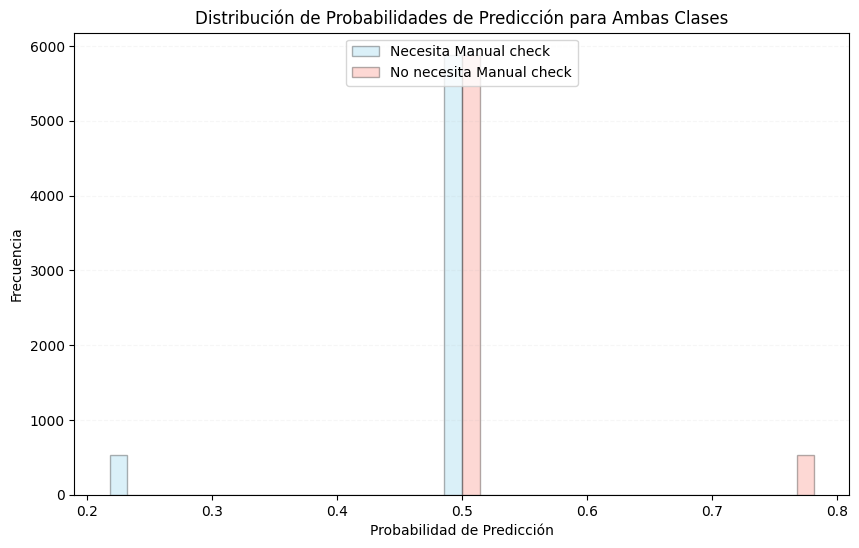

Accuracy: 0.5318585449446954
Classification Report:
               precision    recall  f1-score   support

           0       0.00      0.00      0.00      3005
           1       0.53      1.00      0.69      3414

    accuracy                           0.53      6419
   macro avg       0.27      0.50      0.35      6419
weighted avg       0.28      0.53      0.37      6419



/home/albagd/ProyectoPastaLoca2/myenv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/albagd/ProyectoPastaLoca2/myenv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/albagd/ProyectoPastaLoca2/myenv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.

Text(70.5815972222222, 0.5, 'Realidad')

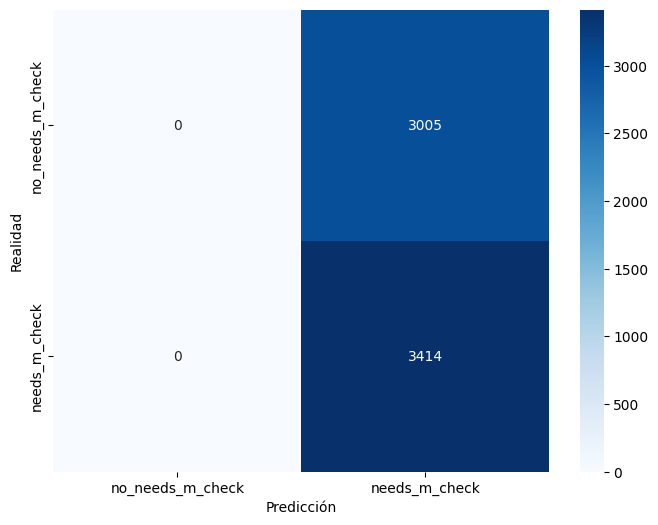

In [18]:
# Entrenamos MODELO RegressiON Logistica sin normalizar datos
y = X_log_L['needs_m_check_recov'].copy()  #Segun moderated_at
X_log_L = X_log_L.drop(columns=['needs_m_check_recov'])

# # Obtener los nombres de las características
feature_names = X_log_L.columns
X=X_log_L

# Divide los datos en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2, random_state=42)

# Crea el clasificador de regresión logística. El 'liblinear' usa metodo de optimización de minimos cuadrados generalizados (L2) y soporta la regularización L1 y L2
clf = LogisticRegression(solver="liblinear")

# Entrena el clasificador
clf.fit(X_train, y_train)

# Realiza predicciones sobre el conjunto de prueba
predicciones = clf.predict(X_test)

# Genera las probabilidades de predicción
predicciones_probabilidades = clf.predict_proba(X_test)

# Muestra las primeras 10 probabilidades de predicción
#predicciones_probabilidades[:10]

# Obtén los coeficientes y asigna los nombres de las características
coeficientes = clf.coef_[0]  # clf.coef_ es un array bidimensional, tomamos la primera fila
feature_coef = list(zip(feature_names, coeficientes))

# Ordena las características por el valor absoluto del coeficiente en orden descendente
feature_coef_sorted = sorted(feature_coef, key=lambda x: abs(x[1]), reverse=True)

# Imprime cada variable junto con su coeficiente ordenado
print("Coeficientes del modelo de regresión logística (ordenados por magnitud):")
for feature, coef in feature_coef_sorted:
    print(f"{feature}: {coef:.8f}")
    
# Crea un histograma de las probabilidades de predicción para ambas clases
plt.figure(figsize=(10, 6)) 

# # Histograma para la clase negativa (need manual check)
plt.hist(predicciones_probabilidades[:, 0], bins=20, color="skyblue", edgecolor="black", alpha=0.3, label="Necesita Manual check")
# Histograma para la clase positiva (no need manual check)
plt.hist(predicciones_probabilidades[:, 1], bins=20, color="salmon", edgecolor="black", alpha=0.3, label="No necesita Manual check")
# Título y etiquetas de los ejes
plt.title("Distribución de Probabilidades de Predicción para Ambas Clases")
plt.xlabel("Probabilidad de Predicción")
plt.ylabel("Frecuencia")
plt.legend(loc="upper center") 
# Muestra la leyenda en el gráfico
plt.grid(axis="y", linestyle="--", alpha=0.1)
plt.show()

# Evaluate model performance
print("Accuracy:", clf.score(X_test, y_test))  # Accuracy score
print("Classification Report:\n", classification_report(y_test, predicciones))  # Classification report

# Genera la matriz de confusión
matriz_confusion = confusion_matrix(y_test, predicciones)
columnas = ['no_needs_m_check', 'needs_m_check'] # 0 para No necesita manual check y 1 para Sí necesita manual check

# Visualiza la matriz de confusión utilizando un mapa de calor

plt.figure(figsize=(8, 6))
sns.heatmap(matriz_confusion, annot=True, fmt='d', cmap='Blues', xticklabels=columnas, yticklabels=columnas)
plt.xlabel("Predicción")
plt.ylabel("Realidad")

In [19]:
# Estandarizar datos

scaler = StandardScaler()
# Estandarizar todas las columnas
normalizado = scaler.fit_transform(X_log_L)
# Convertir de nuevo a DataFrame, preservando nombres de columnas e índices
X = pd.DataFrame(normalizado, columns=X_log_L.columns, index=df.index)

In [20]:
X.describe()

,user_id,created_at_slot,created_at_dow,amount,n_fees,n_backs,n_recovery,n_incidents,n_cr_fe_w,inflation,GBP_EUR,BTC_GBP,unemploy_rate,transfer_type_regular,charge_moment_before,category_nice,category_rejected_direct_debit
count,3.209200e+04,3.209200e+04,3.209200e+04,3.209200e+04,3.209200e+04,3.209200e+04,3.209200e+04,3.209200e+04,3.209200e+04,3.209200e+04,3.209200e+04,3.209200e+04,3.209200e+04,32092.000000,3.209200e+04,3.209200e+04,3.209200e+04
mean,-1.417012e-17,-9.919081e-17,-1.062759e-17,1.417012e-16,-7.085058e-17,-1.417012e-17,3.542529e-17,-4.251035e-17,1.151322e-16,-1.275310e-16,1.700414e-16,7.935265e-16,-1.927136e-15,0.000000,-3.542529e-17,5.668046e-17,7.085058e-18
std,1.000016e+00,1.000016e+00,1.000016e+00,1.000016e+00,1.000016e+00,1.000016e+00,1.000016e+00,1.000016e+00,1.000016e+00,1.000016e+00,1.000016e+00,1.000016e+00,1.000016e+00,1.000016,1.000016e+00,1.000016e+00,1.000016e+00
min,-2.964227e-01,-2.398744e+00,-1.503384e+00,-3.185956e+00,-8.684852e-01,-1.047367e+00,-4.178502e-01,-6.962189e-01,-1.153109e+00,-1.508351e+00,-1.985192e+00,-4.273880e+00,-2.926786e+00,-0.804212,-3.952448e-01,-1.193873e+00,-2.289187e-01
25%,-2.959575e-01,-6.918763e-01,-9.564697e-01,-1.294075e+00,-8.684852e-01,-3.297425e-01,-4.178502e-01,-6.962189e-01,-1.153109e+00,-4.631586e-01,4.651692e-01,-7.841274e-01,-6.392732e-01,-0.804212,-3.952448e-01,-1.193873e+00,-2.289187e-01
50%,-2.954192e-01,6.673159e-02,1.373592e-01,6.364159e-01,1.919641e-02,-3.297425e-01,-4.178502e-01,-3.273390e-01,-1.004438e-02,-1.147610e-01,4.920610e-01,4.632487e-02,2.185440e-01,-0.804212,-3.952448e-01,8.376101e-01,-2.289187e-01
75%,-2.943602e-01,8.253395e-01,6.842736e-01,6.364159e-01,1.919641e-02,3.878823e-01,1.697253e-01,4.104209e-01,-1.004438e-02,2.336365e-01,5.043726e-01,5.414699e-01,7.904221e-01,1.243453,-3.952448e-01,8.376101e-01,-2.289187e-01
max,3.387845e+00,1.963251e+00,1.778102e+00,4.497397e+00,1.244674e+01,6.846505e+00,1.603426e+01,1.147682e+01,1.370673e+01,4.066010e+00,7.208789e-01,2.177864e+00,1.076361e+00,1.243453,2.530077e+00,8.376101e-01,4.368364e+00


Coeficientes del modelo de regresión logística (ordenados por magnitud):
n_recovery: 3.15202812
n_incidents: 2.10248603
category_rejected_direct_debit: 1.68587257
n_fees: -1.32382112
n_backs: -1.09439061
n_cr_fe_w: -0.93129591
charge_moment_before: 0.49901386
transfer_type_regular: -0.44328558
BTC_GBP: -0.36426885
amount: 0.31446707
inflation: -0.24399821
unemploy_rate: 0.21004535
user_id: 0.17951934
category_nice: 0.10034153
GBP_EUR: 0.01010115
created_at_slot: -0.00561471
created_at_dow: -0.00392797


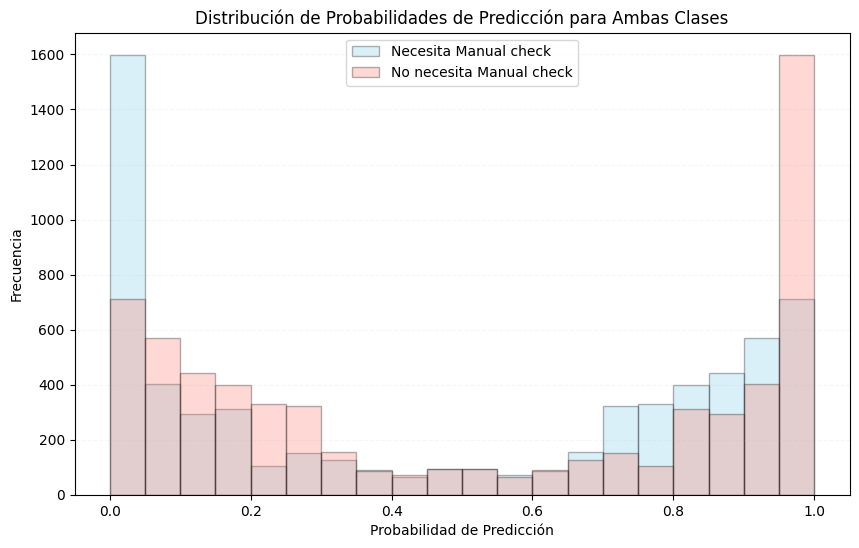

Accuracy: 0.9185231344446175
Classification Report:
               precision    recall  f1-score   support

           0       0.89      0.94      0.92      3005
           1       0.95      0.90      0.92      3414

    accuracy                           0.92      6419
   macro avg       0.92      0.92      0.92      6419
weighted avg       0.92      0.92      0.92      6419



Text(70.5815972222222, 0.5, 'Realidad')

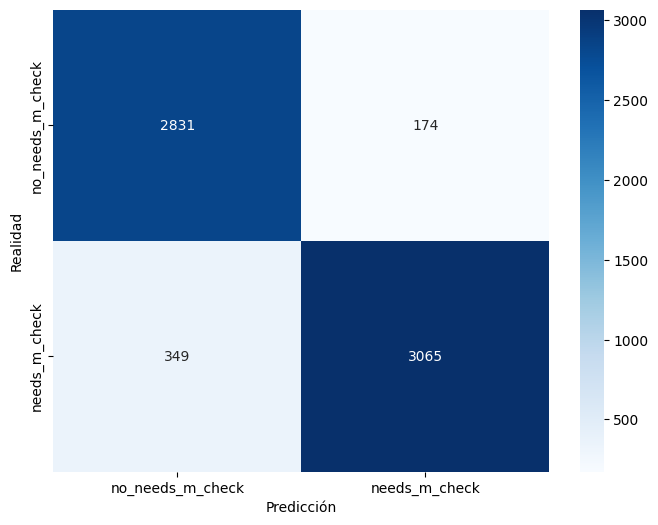

In [21]:
# Pasamos MODELO DE REGRESIÓN LOGISTICA CON TODAS para poder ver después la diferencia al aplicar Ridge y Lasso

# Obtener los nombres de las características
feature_names = X.columns

# Divide los datos en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2, random_state=42)

# Crea el clasificador de regresión logística. El 'liblinear' usa metodo de optimización de minimos cuadrados generalizados (L2) y soporta la regularización L1 y L2
clf = LogisticRegression(solver="liblinear")

# Entrena el clasificador
clf.fit(X_train, y_train)

# Realiza predicciones sobre el conjunto de prueba
predicciones = clf.predict(X_test)

# Genera las probabilidades de predicción
predicciones_probabilidades = clf.predict_proba(X_test)

# Muestra las primeras 10 probabilidades de predicción
#predicciones_probabilidades[:10]

# Obtén los coeficientes y asigna los nombres de las características
coeficientes = clf.coef_[0]  # clf.coef_ es un array bidimensional, tomamos la primera fila
feature_coef = list(zip(feature_names, coeficientes))

# Ordena las características por el valor absoluto del coeficiente en orden descendente
feature_coef_sorted = sorted(feature_coef, key=lambda x: abs(x[1]), reverse=True)

# Imprime cada variable junto con su coeficiente ordenado
print("Coeficientes del modelo de regresión logística (ordenados por magnitud):")
for feature, coef in feature_coef_sorted:
    print(f"{feature}: {coef:.8f}")
    
# Crea un histograma de las probabilidades de predicción para ambas clases
plt.figure(figsize=(10, 6)) 

# # Histograma para la clase negativa (need manual check)
plt.hist(predicciones_probabilidades[:, 0], bins=20, color="skyblue", edgecolor="black", alpha=0.3, label="Necesita Manual check")
# Histograma para la clase positiva (no need manual check)
plt.hist(predicciones_probabilidades[:, 1], bins=20, color="salmon", edgecolor="black", alpha=0.3, label="No necesita Manual check")
# Título y etiquetas de los ejes
plt.title("Distribución de Probabilidades de Predicción para Ambas Clases")
plt.xlabel("Probabilidad de Predicción")
plt.ylabel("Frecuencia")
plt.legend(loc="upper center") 
# Muestra la leyenda en el gráfico
plt.grid(axis="y", linestyle="--", alpha=0.1)
plt.show()

# Evaluate model performance
print("Accuracy:", clf.score(X_test, y_test))  # Accuracy score
print("Classification Report:\n", classification_report(y_test, predicciones))  # Classification report

# Genera la matriz de confusión
matriz_confusion = confusion_matrix(y_test, predicciones)
columnas = ['no_needs_m_check', 'needs_m_check'] # 0 para No necesita manual check y 1 para Sí necesita manual check

# Visualiza la matriz de confusión utilizando un mapa de calor

plt.figure(figsize=(8, 6))
sns.heatmap(matriz_confusion, annot=True, fmt='d', cmap='Blues', xticklabels=columnas, yticklabels=columnas)
plt.xlabel("Predicción")
plt.ylabel("Realidad")

In [22]:
# Aplicar Penalizaciones Ridge y Lasso para Regresion Logistica

# Modelo con penalización L1 (similar a Lasso)
logreg_l1 = LogisticRegression(penalty='l1', solver='saga', C=10, random_state=42, max_iter=1000) #probar tb con solver='liblinear'
logreg_l1.fit(X_train, y_train)

# Modelo con penalización L2 (similar a Ridge)
logreg_l2 = LogisticRegression(penalty='l2', solver='lbfgs', C=10, random_state=42, max_iter=1000)
logreg_l2.fit(X_train, y_train)

# Predicciones
y_pred_l1 = logreg_l1.predict(X_test)
y_pred_l2 = logreg_l2.predict(X_test)

# Evaluación (por ejemplo, exactitud)
from sklearn.metrics import accuracy_score
print("Exactitud L1 (LASSO):", accuracy_score(y_test, y_pred_l1))
print("Exactitud L2 (Ridge):", accuracy_score(y_test, y_pred_l2))


Exactitud L1 (LASSO): 0.9188347094563016
Exactitud L2 (Ridge): 0.9188347094563016


In [23]:
# Extraer los coeficientes para la L1
coefs = logreg_l1.coef_[0]  # Para regresión logística binaria, es un vector 1D

# Crear un DataFrame para visualizar los coeficientes junto con las características
importancia = pd.DataFrame({
    'Característica': X_train.columns,
    'Coeficiente': coefs
})

# Ordenar por la magnitud de los coeficientes
importancia = importancia.reindex(importancia['Coeficiente'].abs().sort_values(ascending=False).index)

# Mostrar las características con coeficientes no nulos (para Lasso)
importancia_no_nula = importancia[importancia['Coeficiente'] != 0]

print("Características importantes para LASSO:")
print(importancia_no_nula)

Características importantes para LASSO:
                    Característica  Coeficiente
6                       n_recovery     3.172480
16  category_rejected_direct_debit     2.231357
7                      n_incidents     2.106820
4                           n_fees    -1.331929
5                          n_backs    -1.096842
8                        n_cr_fe_w    -0.933990
14            charge_moment_before     0.501506
13           transfer_type_regular    -0.445754
11                         BTC_GBP    -0.365330
3                           amount     0.315771
9                        inflation    -0.244456
12                   unemploy_rate     0.210994
0                          user_id     0.179510
15                   category_nice     0.102086
10                         GBP_EUR     0.010067
1                  created_at_slot    -0.005516
2                   created_at_dow    -0.003892


In [24]:
# Extraer los coeficientes para la L2
coefs2 = logreg_l2.coef_[0]  # Para regresión logística binaria, es un vector 1D

# Crear un DataFrame para visualizar los coeficientes junto con las características
importancia2 = pd.DataFrame({
    'Característica': X_train.columns,
    'Coeficiente': coefs2
})

# Ordenar por la magnitud de los coeficientes
importancia2 = importancia2.reindex(importancia2['Coeficiente'].abs().sort_values(ascending=False).index)

# Mostrar las características con coeficientes no nulos (para Lasso)
importancia_no_nula2 = importancia2[importancia2['Coeficiente'] != 0]

print("Características importantes para RIDGE:")
print(importancia_no_nula2)

Características importantes para RIDGE:
                    Característica  Coeficiente
6                       n_recovery     3.168580
16  category_rejected_direct_debit     2.116469
7                      n_incidents     2.108188
4                           n_fees    -1.330897
5                          n_backs    -1.097143
8                        n_cr_fe_w    -0.933461
14            charge_moment_before     0.501208
13           transfer_type_regular    -0.446898
11                         BTC_GBP    -0.364791
3                           amount     0.315510
9                        inflation    -0.244305
12                   unemploy_rate     0.209666
0                          user_id     0.179646
15                   category_nice     0.101564
10                         GBP_EUR     0.010432
1                  created_at_slot    -0.005614
2                   created_at_dow    -0.003438


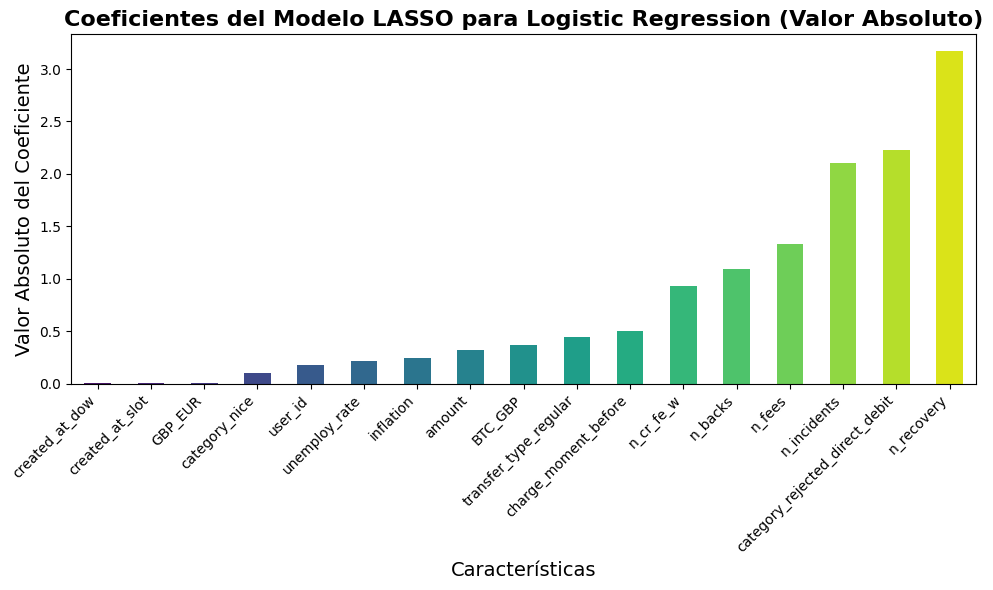

In [25]:
# Graficamos los coeficientes ordenados por valor absoluto
plt.figure(figsize=(10, 6))

# Convertir 'coefs' a un pandas.Series
coefs_series = pd.Series(coefs, index=X_train.columns)

# Ordenar los coeficientes de menor a mayor (en valor absoluto)
coefs_series = coefs_series.abs().sort_values(ascending=True)

# Ordenar los coeficientes de menor a mayor (invirtiendo el orden)
coefs_series.plot(kind='bar', color=sns.color_palette("viridis", n_colors=len(coefs_series)))

# Añadimos el título y etiquetas a los ejes
plt.title('Coeficientes del Modelo LASSO para Logistic Regression (Valor Absoluto)', fontsize=16, weight='bold')
plt.xlabel('Características', fontsize=14)
plt.ylabel('Valor Absoluto del Coeficiente', fontsize=14)
# Ajustamos las etiquetas del eje x para mejorar la legibilidad
plt.xticks(rotation=45, ha='right')
# Mostramos la gráfica con un diseño ajustado
plt.tight_layout() # Ajuste del espaciado para evitar solapamientos
plt.show()

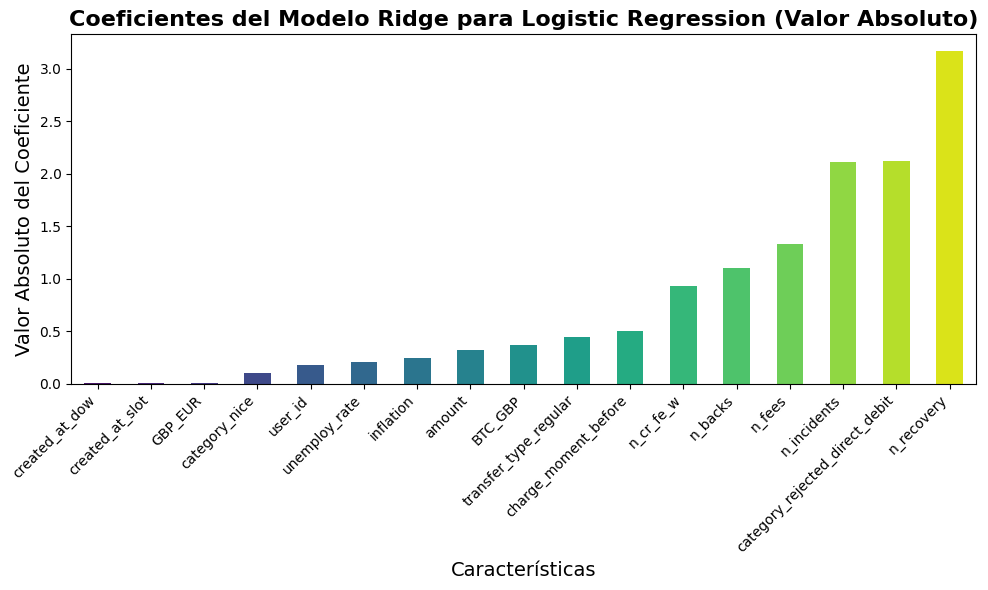

In [26]:
# Graficamos los coeficientes ordenados por valor absoluto
plt.figure(figsize=(10, 6))

# Convertir 'coefs' a un pandas.Series
coefs_series2 = pd.Series(coefs2, index=X_train.columns)

# Ordenar los coeficientes de menor a mayor (en valor absoluto)
coefs_series2 = coefs_series2.abs().sort_values(ascending=True)

# Ordenar los coeficientes de menor a mayor (invirtiendo el orden)
coefs_series2.plot(kind='bar', color=sns.color_palette("viridis", n_colors=len(coefs_series)))

# Añadimos el título y etiquetas a los ejes
plt.title('Coeficientes del Modelo Ridge para Logistic Regression (Valor Absoluto)', fontsize=16, weight='bold')
plt.xlabel('Características', fontsize=14)
plt.ylabel('Valor Absoluto del Coeficiente', fontsize=14)
# Ajustamos las etiquetas del eje x para mejorar la legibilidad
plt.xticks(rotation=45, ha='right')
# Mostramos la gráfica con un diseño ajustado
plt.tight_layout() # Ajuste del espaciado para evitar solapamientos
plt.show()

In [27]:
# Buscamos el C optimo (el alpha optimo) para estas penalizaciones

from sklearn.linear_model import LogisticRegressionCV

# Definir valores de C para probar
C_values = [0.001, 0.01, 0.1, 1, 10, 100]

# Modelo con penalización L1
logreg_l1 = LogisticRegressionCV(
    Cs=C_values,  # Valores de C a probar
    cv=5,         # Número de folds para validación cruzada
    penalty='l1',
    solver='saga', # Solver compatible con L1
    max_iter=1000,
    random_state=42
)
logreg_l1.fit(X_train, y_train)

# Modelo con penalización L2
logreg_l2 = LogisticRegressionCV(
    Cs=C_values,  # Valores de C a probar
    cv=5,         # Número de folds para validación cruzada
    penalty='l2',
    solver='lbfgs', # Solver compatible con L2
    max_iter=1000,
    random_state=42
)
logreg_l2.fit(X_train, y_train)

# Encontrar los valores óptimos de C
optimal_C_l1 = logreg_l1.C_[0]
optimal_C_l2 = logreg_l2.C_[0]

print(f"Mejor valor de C para penalización L1: {optimal_C_l1}")
print(f"Mejor valor de C para penalización L2: {optimal_C_l2}")


Mejor valor de C para penalización L1: 1.0
Mejor valor de C para penalización L2: 10.0


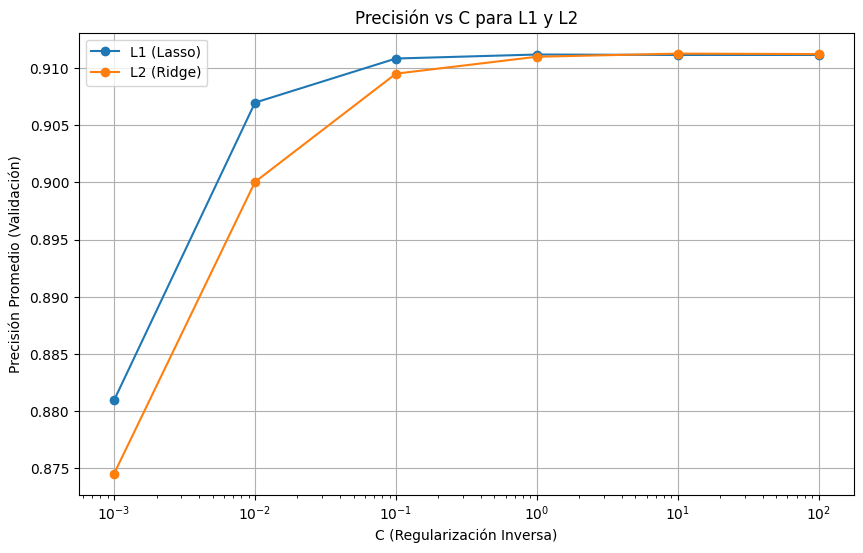

In [28]:
# Graficar precisión promedio para cada C
plt.figure(figsize=(10, 6))
plt.plot(C_values, logreg_l1.scores_[1].mean(axis=0), label='L1 (Lasso)', marker='o')
plt.plot(C_values, logreg_l2.scores_[1].mean(axis=0), label='L2 (Ridge)', marker='o')

plt.xscale('log')  # Escala logarítmica para C
plt.xlabel('C (Regularización Inversa)')
plt.ylabel('Precisión Promedio (Validación)')
plt.title('Precisión vs C para L1 y L2')
plt.legend()
plt.grid(True)
plt.show()

In [29]:
# Ver los puntajes promedio por validación cruzada para cada C
scores_l1 = logreg_l1.scores_[1].mean(axis=0)  # Precisión promedio para cada valor de C
scores_l2 = logreg_l2.scores_[1].mean(axis=0)

# Mostrar C óptimos
print("Puntajes promedio para L1:", scores_l1)
print("Puntajes promedio para L2:", scores_l2)

# Comprobar el índice del mejor puntaje (C óptimo)
optimal_index_l1 = scores_l1.argmax()
optimal_index_l2 = scores_l2.argmax()

print(f"Índice óptimo para L1: {optimal_index_l1}, Mejor C: {logreg_l1.Cs_[optimal_index_l1]}")
print(f"Índice óptimo para L2: {optimal_index_l2}, Mejor C: {logreg_l2.Cs_[optimal_index_l2]}")

Puntajes promedio para L1: [0.88096423 0.90698391 0.91084022 0.91119077 0.91115181 0.91115181]
Puntajes promedio para L2: [0.87453737 0.90005053 0.90951578 0.91099599 0.91126866 0.91122972]
Índice óptimo para L1: 3, Mejor C: 1.0
Índice óptimo para L2: 4, Mejor C: 10.0


In [30]:
# Probamos MODELO REGRESION LOGISTICA con este analisis 

# Entrenar el modelo final con el valor óptimo de C
logreg_l1_optimal = LogisticRegression(penalty='l1', solver='saga', C=optimal_C_l1, random_state=42, max_iter=1000)
logreg_l2_optimal = LogisticRegression(penalty='l2', solver='saga', C=optimal_C_l2, random_state=42, max_iter=1000)

# Entrenar los modelos con el valor de C óptimo
logreg_l1_optimal.fit(X_train, y_train)
logreg_l2_optimal.fit(X_train, y_train)

LogisticRegression(C=np.float64(10.0), max_iter=1000, random_state=42,
                   solver='saga')

In [31]:
# Realizar predicciones en el conjunto de prueba
y_pred_l1 = logreg_l1_optimal.predict(X_test)
y_pred_l2 = logreg_l2_optimal.predict(X_test)

# Evaluar el desempeño del modelo L1
print("Evaluación del modelo Lasso (L1):")
print("Precisión:", accuracy_score(y_test, y_pred_l1))
print("Reporte de clasificación L1:\n", classification_report(y_test, y_pred_l1))

# Evaluar el desempeño del modelo L2
print("Evaluación del modelo Ridge (L2):")
print("Precisión:", accuracy_score(y_test, y_pred_l2))
print("Reporte de clasificación L2:\n", classification_report(y_test, y_pred_l2))

Evaluación del modelo Lasso (L1):
Precisión: 0.9188347094563016
Reporte de clasificación L1:
               precision    recall  f1-score   support

           0       0.89      0.94      0.92      3005
           1       0.95      0.90      0.92      3414

    accuracy                           0.92      6419
   macro avg       0.92      0.92      0.92      6419
weighted avg       0.92      0.92      0.92      6419

Evaluación del modelo Ridge (L2):
Precisión: 0.9188347094563016
Reporte de clasificación L2:
               precision    recall  f1-score   support

           0       0.89      0.94      0.92      3005
           1       0.95      0.90      0.92      3414

    accuracy                           0.92      6419
   macro avg       0.92      0.92      0.92      6419
weighted avg       0.92      0.92      0.92      6419



Coeficientes del modelo Ridge (L2) (ordenados por magnitud):
n_recovery: 3.17137926
category_rejected_direct_debit: 2.11967883
n_incidents: 2.10666112
n_fees: -1.33160666
n_backs: -1.09674084
n_cr_fe_w: -0.93390636
charge_moment_before: 0.50141809
transfer_type_regular: -0.44566872
BTC_GBP: -0.36539939
amount: 0.31574208
inflation: -0.24447993
unemploy_rate: 0.21103701
user_id: 0.17955262
category_nice: 0.10206559
GBP_EUR: 0.01010141
created_at_slot: -0.00555666
created_at_dow: -0.00390323

Coeficientes del modelo Lasso (L1) (ordenados por magnitud):
n_recovery: 3.16461038
n_incidents: 2.10442751
category_rejected_direct_debit: 1.82608414
n_fees: -1.32720560
n_backs: -1.09545999
n_cr_fe_w: -0.93228689
charge_moment_before: 0.50000335
transfer_type_regular: -0.44426009
BTC_GBP: -0.36359009
amount: 0.31480321
inflation: -0.24379215
unemploy_rate: 0.20969969
user_id: 0.17909407
category_nice: 0.10037251
GBP_EUR: 0.00975117
created_at_slot: -0.00521199
created_at_dow: -0.00381670


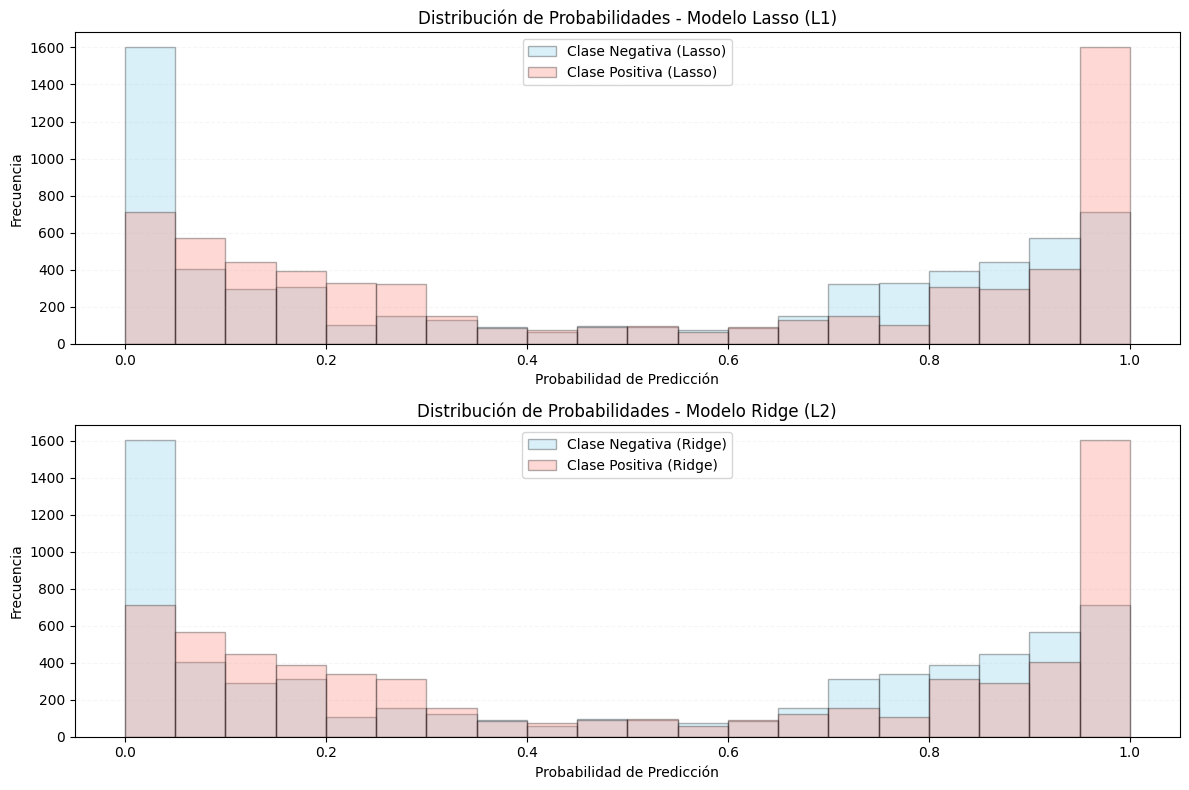

Desempeño del Modelo Lasso (L1):
Accuracy: 0.9188347094563016
Classification Report:
               precision    recall  f1-score   support

           0       0.89      0.94      0.92      3005
           1       0.95      0.90      0.92      3414

    accuracy                           0.92      6419
   macro avg       0.92      0.92      0.92      6419
weighted avg       0.92      0.92      0.92      6419


Desempeño del Modelo Ridge (L2):
Accuracy: 0.9188347094563016
Classification Report:
               precision    recall  f1-score   support

           0       0.89      0.94      0.92      3005
           1       0.95      0.90      0.92      3414

    accuracy                           0.92      6419
   macro avg       0.92      0.92      0.92      6419
weighted avg       0.92      0.92      0.92      6419



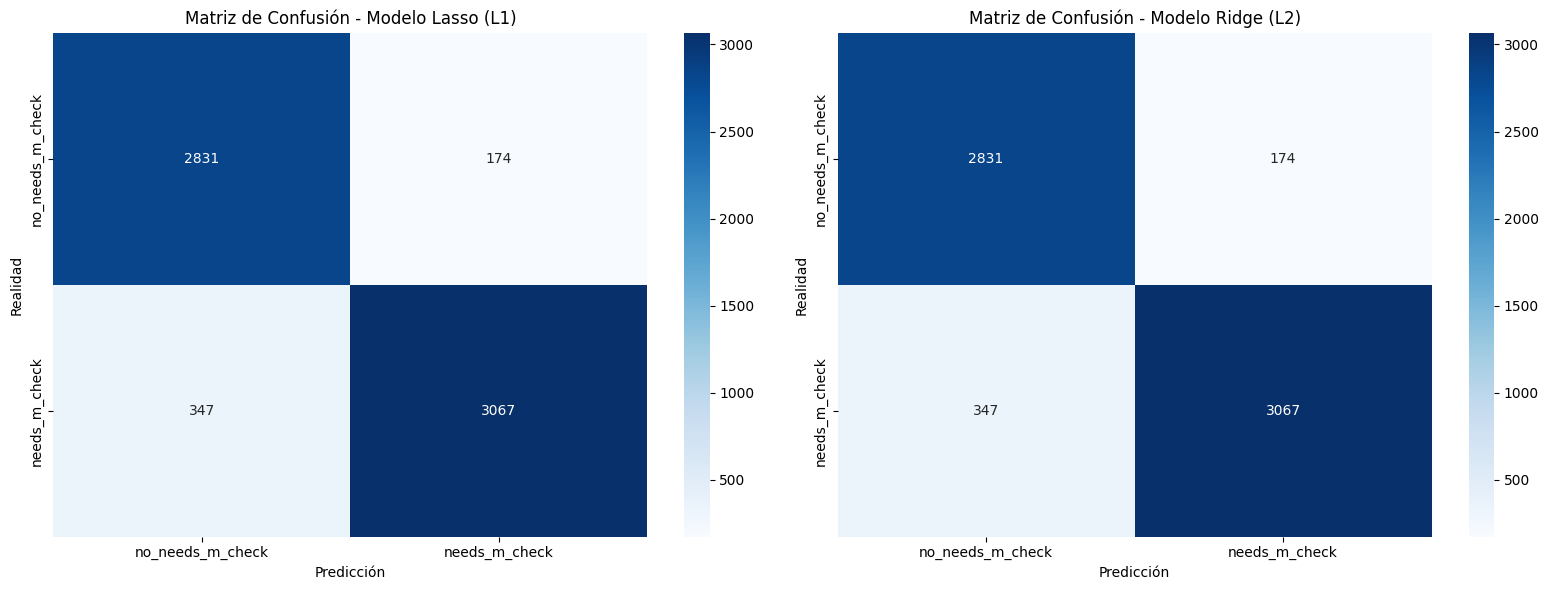

In [32]:
# Genera las probabilidades de predicción para ambos modelos
predicciones_prob_l1 = logreg_l1_optimal.predict_proba(X_test)
predicciones_prob_l2 = logreg_l2_optimal.predict_proba(X_test)

# Obtén los coeficientes de ambos modelos
coef_l1 = logreg_l1_optimal.coef_[0]  # Array unidimensional
coef_l2 = logreg_l2_optimal.coef_[0]

# Asocia los coeficientes con los nombres de las características
feature_coef_l1 = list(zip(feature_names, coef_l1))
feature_coef_l2 = list(zip(feature_names, coef_l2))

# Ordena las características por valor absoluto del coeficiente
feature_coef_l1_sorted = sorted(feature_coef_l1, key=lambda x: abs(x[1]), reverse=True)
feature_coef_l2_sorted = sorted(feature_coef_l2, key=lambda x: abs(x[1]), reverse=True)

# Imprime las características ordenadas por magnitud del coeficiente
print("Coeficientes del modelo Ridge (L2) (ordenados por magnitud):")
for feature, coef in feature_coef_l2_sorted:
    print(f"{feature}: {coef:.8f}")

print("\nCoeficientes del modelo Lasso (L1) (ordenados por magnitud):")
for feature, coef in feature_coef_l1_sorted:
    print(f"{feature}: {coef:.8f}")

# Crea histogramas para ambas clases y modelos
plt.figure(figsize=(12, 8))
plt.subplot(2, 1, 1)
plt.hist(predicciones_prob_l1[:, 0], bins=20, color="skyblue", edgecolor="black", alpha=0.3, label="Clase Negativa (Lasso)")
plt.hist(predicciones_prob_l1[:, 1], bins=20, color="salmon", edgecolor="black", alpha=0.3, label="Clase Positiva (Lasso)")
plt.title("Distribución de Probabilidades - Modelo Lasso (L1)")
plt.xlabel("Probabilidad de Predicción")
plt.ylabel("Frecuencia")
plt.legend(loc="upper center")
plt.grid(axis="y", linestyle="--", alpha=0.1)

plt.subplot(2, 1, 2)
plt.hist(predicciones_prob_l2[:, 0], bins=20, color="skyblue", edgecolor="black", alpha=0.3, label="Clase Negativa (Ridge)")
plt.hist(predicciones_prob_l2[:, 1], bins=20, color="salmon", edgecolor="black", alpha=0.3, label="Clase Positiva (Ridge)")
plt.title("Distribución de Probabilidades - Modelo Ridge (L2)")
plt.xlabel("Probabilidad de Predicción")
plt.ylabel("Frecuencia")
plt.legend(loc="upper center")
plt.grid(axis="y", linestyle="--", alpha=0.1)
plt.tight_layout()
plt.show()

# Evaluación de desempeño para ambos modelos
from sklearn.metrics import classification_report, confusion_matrix

print("Desempeño del Modelo Lasso (L1):")
print("Accuracy:", logreg_l1_optimal.score(X_test, y_test))
print("Classification Report:\n", classification_report(y_test, y_pred_l1))

print("\nDesempeño del Modelo Ridge (L2):")
print("Accuracy:", logreg_l2_optimal.score(X_test, y_test))
print("Classification Report:\n", classification_report(y_test, y_pred_l2))

# Generar matrices de confusión para ambos modelos
matriz_confusion_l1 = confusion_matrix(y_test, y_pred_l1)
matriz_confusion_l2 = confusion_matrix(y_test, y_pred_l2)

# Visualizar matrices de confusión usando mapas de calor
plt.figure(figsize=(16, 6))

plt.subplot(1, 2, 1)
sns.heatmap(matriz_confusion_l1, annot=True, fmt='d', cmap='Blues', xticklabels=columnas, yticklabels=columnas)
plt.title("Matriz de Confusión - Modelo Lasso (L1)")
plt.xlabel("Predicción")
plt.ylabel("Realidad")

plt.subplot(1, 2, 2)
sns.heatmap(matriz_confusion_l2, annot=True, fmt='d', cmap='Blues', xticklabels=columnas, yticklabels=columnas)
plt.title("Matriz de Confusión - Modelo Ridge (L2)")
plt.xlabel("Predicción")
plt.ylabel("Realidad")

plt.tight_layout()
plt.show()


In [33]:
# Comparación resultados entre MODELO BASE y el modelo entrenado según LASSO y RIDGE
from sklearn.metrics import roc_auc_score
# ROC-AUC para cada modelo
roc_auc_base = roc_auc_score(y_test, predicciones)
roc_auc_ridge = roc_auc_score(y_test, y_pred_l2)
roc_auc_lasso = roc_auc_score(y_test, y_pred_l1)

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

# Base model
accuracy_base = accuracy_score(y_test, predicciones)
precision_base = precision_score(y_test, predicciones)
recall_base = recall_score(y_test, predicciones)
f1_base = f1_score(y_test, predicciones)
roc_auc_base = roc_auc_score(y_test, predicciones)

# Ridge model
accuracy_ridge = accuracy_score(y_test, y_pred_l2)
precision_ridge = precision_score(y_test, y_pred_l2)
recall_ridge = recall_score(y_test, y_pred_l2)
f1_ridge = f1_score(y_test, y_pred_l2)
roc_auc_ridge = roc_auc_score(y_test, y_pred_l2)

# Lasso model
accuracy_lasso = accuracy_score(y_test, y_pred_l1)
precision_lasso = precision_score(y_test, y_pred_l1)
recall_lasso = recall_score(y_test, y_pred_l1)
f1_lasso = f1_score(y_test, y_pred_l1)
roc_auc_lasso = roc_auc_score(y_test, y_pred_l1)

# Comparar métricas clave en una tabla

metricas = {
    "Modelo": ["Base", "Ridge", "Lasso"],
    "Accuracy": [accuracy_base, accuracy_ridge, accuracy_lasso],
    "Precision": [precision_base, precision_ridge, precision_lasso],
    "Recall": [recall_base, recall_ridge, recall_lasso],
    "F1-Score": [f1_base, f1_ridge, f1_lasso],
    "ROC-AUC": [roc_auc_base, roc_auc_ridge, roc_auc_lasso],
}

df_metricas = pd.DataFrame(metricas)
print(df_metricas)


  Modelo  Accuracy  Precision    Recall  F1-Score   ROC-AUC
0   Base  0.918523   0.946280  0.897774  0.921389  0.919935
1  Ridge  0.918835   0.946313  0.898360  0.921713  0.920228
2  Lasso  0.918835   0.946313  0.898360  0.921713  0.920228
